# **1. Import Libraries**

In [31]:
# Data Analysis and Computer Vision
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import random
import warnings
from collections import Counter
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# TensorFlow
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0, DenseNet121, ResNet50, VGG16
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.metrics import Precision, Recall, AUC

# Sci-kit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.utils import class_weight

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [33]:
# Directories
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
valid_dir = os.path.join(base_dir, "val")

In [34]:
# Allow reproducability
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# **2. Data Analysis**

## **2.1 Image Count Analysis**

In [35]:
# Count images in each category
data_counts = {}
for split in ['train', 'test', 'val']:
  split_dir = os.path.join(base_dir, split)
  data_counts[split] = {}

  for category in ['NORMAL', 'PNEUMONIA']:
    category_dir = os.path.join(split_dir, category)
    if os.path.exists(category_dir):
      num_images = len(os.listdir(category_dir))
      data_counts[split][category] = num_images
      print(f"{split} / {category}: {num_images} images")
    else:
      data_counts[split][category] = 0

train / NORMAL: 1342 images
train / PNEUMONIA: 3876 images
test / NORMAL: 234 images
test / PNEUMONIA: 390 images
val / NORMAL: 9 images
val / PNEUMONIA: 9 images


## **2.2 Class Distribution Analysis**

In [36]:
def view_class_distribution(data_counts):
  """
  Displays class distributions for a folder
  """
  plt.pie(data_counts, labels=['Normal', 'Pneumonia'], autopct='%1.1f%%',
          colors=['#2ecc71', '#e74c3c'], startangle=90, explode=(0.05, 0))
  plt.title(f'Class Distribution (n = {sum(data_counts)})')
  plt.show()

In [37]:
train_counts = [data_counts['train']['NORMAL'], data_counts['train']['PNEUMONIA']]
test_counts = [data_counts['test']['NORMAL'], data_counts['test']['PNEUMONIA']]
val_counts = [data_counts['val']['NORMAL'], data_counts['val']['PNEUMONIA']]

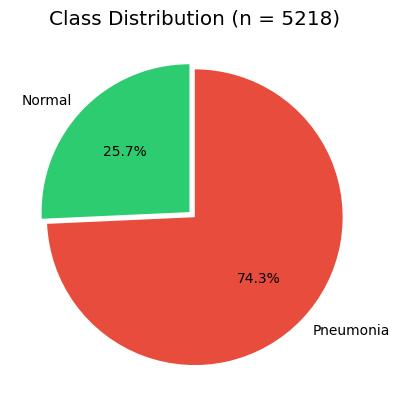

In [38]:
# Train distribution
view_class_distribution(train_counts)

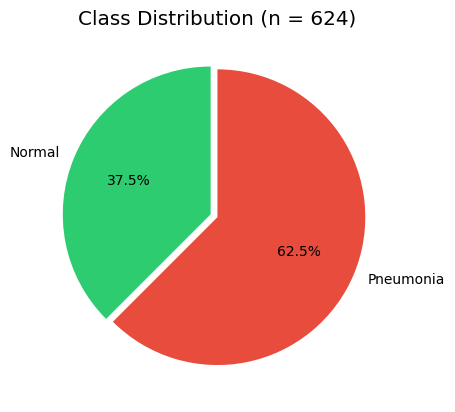

In [39]:
# Test distribution
view_class_distribution(test_counts)

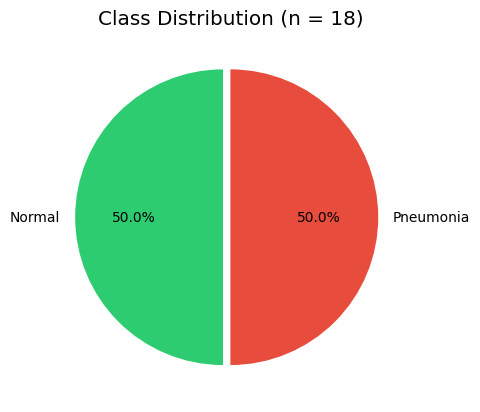

In [40]:
# Validation distribution
view_class_distribution(val_counts)

## **2.3 Imbalance Ratio Analysis**

In [43]:
ratio = data_counts['train']['PNEUMONIA'] / data_counts['train']['NORMAL']
print(f"Class Imbalance Ratio: {ratio:.3f}")

Class Imbalance Ratio: 2.888


## **2.4 Image Analysis**

In [58]:
samples = []

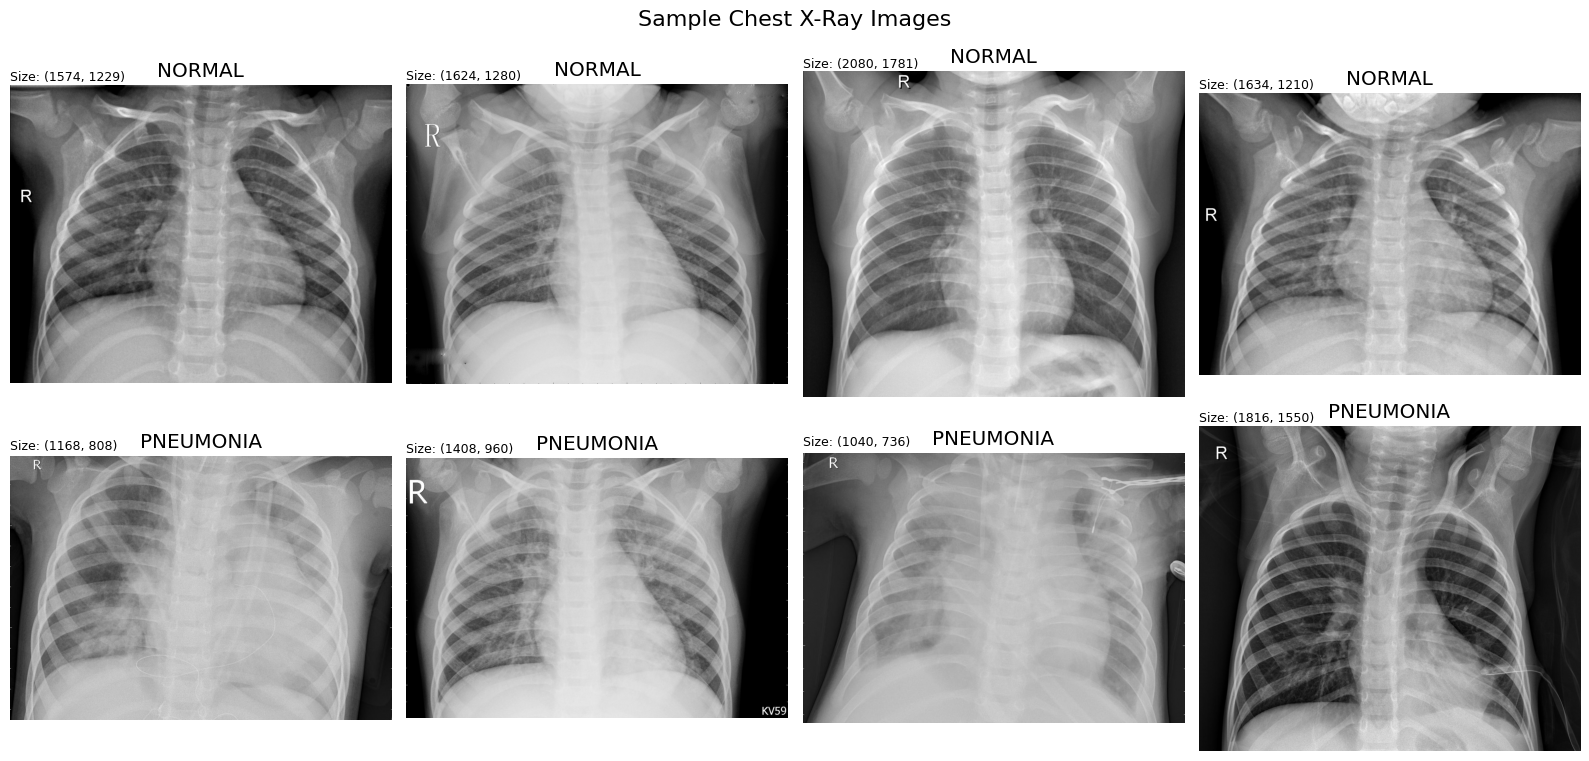

In [59]:
fig, axes = plt.subplots(2,4, figsize=(16,8))

for label in ['NORMAL', 'PNEUMONIA']:
  label_path = os.path.join(train_dir, label)
  img_files = [f for f in os.listdir(label_path) if f.endswith(('.jpeg', '.jpg'))]

  # Random 4 samples (filenames) for the current label
  selected_filenames = random.sample(img_files, 4)

  for img_file_name in selected_filenames:
    img_path = os.path.join(label_path, img_file_name)
    img = Image.open(img_path)
    samples.append((img, label))

# Display samples
for i, tup in enumerate(samples):
  row = i // 4
  col = i % 4

  axes[row, col].imshow(tup[0], cmap='gray')
  axes[row, col].set_title(tup[1])
  axes[row, col].axis('off')

  axes[row, col].text(0, -20, f'Size: {tup[0].size}', fontsize=9)

plt.suptitle('Sample Chest X-Ray Images', fontsize=16)
plt.tight_layout()
plt.show()